# Importación de librerias

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer


In [2]:
print("Versión pandas",pd.__version__)
print("Version seaborn", sns.__version__)
!python --version

Versión pandas 2.0.2
Version seaborn 0.12.2
Python 3.11.3


# Cargar datos

In [3]:
CWD_1 = os.getcwd()
DATA_PATH_1 = os.path.join(CWD_1,"data")
FILE_NAME_1 = "2017_lloguer_preu_trim.csv"
lloguer = os.path.join(DATA_PATH_1,FILE_NAME_1)

In [4]:
CWD_2 = os.getcwd()
DATA_PATH_2 = os.path.join(CWD_2,"data")
FILE_NAME_2 = "2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv"
poblacio_soroll = os.path.join(DATA_PATH_2,FILE_NAME_2)

In [5]:
df_lloguer = pd.read_csv(lloguer)
df_poblacio = pd.read_csv(poblacio_soroll)

# Funciones

In [6]:
# Creamos una función simple para hacer un report simple sobre los DataFrame suministrados
def report_df(dataframe, verbose = True):
    print("El tamaño del dataset es", dataframe.shape[0], "filas y", dataframe.shape[1], "columnas")
    print()
    print(dataframe.info(verbose = verbose))
    total_nulos = dataframe.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")
    print()
    print("Hay", dataframe.duplicated().sum(), "duplicados")


In [7]:
# Función para convertir columnas categoricas a numéricas de cara a preprocesar los datos y preparlos para un modelo
def OHE (dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name],prefix=column_name)
    dataframe = pd.concat([dataframe,_dummy_dataset],axis=1)
    return dataframe.drop(column_name,axis=1)

In [8]:
def juntar_etiquetas(dataframe,column,value_contain,new_value):
    dataframe.loc[dataframe[column].str.contains(value_contain), column] = new_value

# df_lloguer -- análisis y limpieza

In [9]:
report_df(df_lloguer)

df_lloguer.head(2)

El tamaño del dataset es 584 filas y 8 columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Any             584 non-null    int64  
 1   Trimestre       584 non-null    int64  
 2   Codi_Districte  584 non-null    int64  
 3   Nom_Districte   584 non-null    object 
 4   Codi_Barri      584 non-null    int64  
 5   Nom_Barri       584 non-null    object 
 6   Lloguer_mitja   584 non-null    object 
 7   Preu            546 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 36.6+ KB
None

Tenemos un total de 38 nulos

Hay 0 duplicados


,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,2017,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,2017,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26


In [10]:
df_lloguer.isnull().sum()

Any                0
Trimestre          0
Codi_Districte     0
Nom_Districte      0
Codi_Barri         0
Nom_Barri          0
Lloguer_mitja      0
Preu              38
dtype: int64

In [11]:
df_lloguer[df_lloguer['Preu'].isnull()]

,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
11,2017,1,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
41,2017,1,7,Horta-Guinardó,42,la Clota,Lloguer mitjà mensual (Euros/mes),NaN
46,2017,1,8,Nou Barris,47,Can Peguera,Lloguer mitjà mensual (Euros/mes),NaN
55,2017,1,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN
57,2017,1,9,Sant Andreu,58,Baró de Viver,Lloguer mitjà mensual (Euros/mes),NaN
84,2017,2,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
114,2017,2,7,Horta-Guinardó,42,la Clota,Lloguer mitjà mensual (Euros/mes),NaN
126,2017,2,8,Nou Barris,54,Torre Baró,Lloguer mitjà mensual (Euros/mes),NaN
130,2017,2,9,Sant Andreu,58,Baró de Viver,Lloguer mitjà mensual (Euros/mes),NaN
157,2017,3,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN


In [12]:
df_lloguer[df_lloguer['Preu'].isnull()]['Nom_Barri'].unique()   
#Vemos en que barrios tenemos los nulos para buscar algún patron y decidir como imputarlos mejor

array(['la Marina del Prat Vermell', 'la Clota', 'Can Peguera',
       'Vallbona', 'Baró de Viver', 'Torre Baró'], dtype=object)

In [13]:
df_lloguer[df_lloguer['Nom_Barri']=='la Marina del Prat Vermell']
#Análizamos un barrio con valores nulos al azar

,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
11,2017,1,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
84,2017,2,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
157,2017,3,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
230,2017,4,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
303,2017,1,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà per superfície (Euros/m2 mes),NaN
376,2017,2,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà per superfície (Euros/m2 mes),NaN
449,2017,3,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà per superfície (Euros/m2 mes),NaN
522,2017,4,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà per superfície (Euros/m2 mes),NaN


In [14]:
df_lloguer[df_lloguer['Nom_Districte']=='Sants-Montjuïc']['Codi_Barri'].unique()
# Observamos como se compone cada distrito, no depende de un único barrio, sino que puede contener varios

array([11, 12, 13, 14, 15, 16, 17, 18], dtype=int64)

In [15]:
df_lloguer.describe(include=np.number).T   #Realizamos un describe de variables númericas para ver su distribución

,count,mean,std,min,25%,50%,75%,max
Any,584.0,2017.000000,0.000000,2017.00,2017.000,2017.000,2017.0000,2017.00
Trimestre,584.0,2.500000,1.118992,1.00,1.750,2.500,3.2500,4.00
Codi_Districte,584.0,6.246575,2.790726,1.00,4.000,7.000,8.0000,10.00
Codi_Barri,584.0,37.000000,21.089371,1.00,19.000,37.000,55.0000,73.00
Preu,546.0,421.009231,446.178147,4.45,12.645,161.565,770.3475,1882.42


In [16]:
df_lloguer.describe(exclude=np.number).T   #Realizamos un describe de variables categóricas para ver su distribución

,count,unique,top,freq
Nom_Districte,584,10,Nou Barris,104
Nom_Barri,584,73,el Raval,8
Lloguer_mitja,584,2,Lloguer mitjà mensual (Euros/mes),292


#### Observamos que tenemos un Datset de 10 Distritos distintos y con 73 Barrios, como hemos comprobado antes, cada Distrito esta compuesto de varios Barrios. De ahí que obtengamos un Dataset de 292 filas. Si comprobamos además el patrón de Lloguer_mitja podemos intuir que puede dividirse en 2. Por un lado Precio medio mensual para cada barrio y distrito, de ahí las 292 filas y por otro lado el precio medio por m2 por barrio y distrito de ahí las otras 292 filas. En total conforman nuestro dataset de 584 filas. Veremos más adelante como tratamos esto.

#### También vemos que hay columnas sin varianza como el caso del año,siempre es 2017, por lo tanto no nos aporta información útil de cara a hacer un futuro modelo y por eso lo eliminamos utilizando esa función lambda.

In [17]:
list_vars_non_variance = [column for column in df_lloguer.columns if df_lloguer[column].nunique(dropna = False) == 1]
df_lloguer.drop(list_vars_non_variance, axis = 1, inplace = True)

In [18]:
df_lloguer.head(1)

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99


In [19]:
df_lloguer[df_lloguer['Lloguer_mitja']=="Lloguer mitjà mensual (Euros/mes)"]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26
2,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),722.78
3,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà mensual (Euros/mes),895.28
4,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà mensual (Euros/mes),871.08
...,...,...,...,...,...,...,...
287,4,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,Lloguer mitjà mensual (Euros/mes),1233.01
288,4,10,Sant Martí,70,el Besòs i el Maresme,Lloguer mitjà mensual (Euros/mes),621.32
289,4,10,Sant Martí,71,Provençals del Poblenou,Lloguer mitjà mensual (Euros/mes),864.09
290,4,10,Sant Martí,72,Sant Martí de Provençals,Lloguer mitjà mensual (Euros/mes),790.58


In [20]:
df_lloguer[df_lloguer['Lloguer_mitja']!="Lloguer mitjà mensual (Euros/mes)"]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
292,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.50
293,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà per superfície (Euros/m2 mes),14.14
294,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà per superfície (Euros/m2 mes),19.46
295,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà per superfície (Euros/m2 mes),15.01
296,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà per superfície (Euros/m2 mes),12.77
...,...,...,...,...,...,...,...
579,4,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,Lloguer mitjà per superfície (Euros/m2 mes),16.51
580,4,10,Sant Martí,70,el Besòs i el Maresme,Lloguer mitjà per superfície (Euros/m2 mes),10.40
581,4,10,Sant Martí,71,Provençals del Poblenou,Lloguer mitjà per superfície (Euros/m2 mes),12.66
582,4,10,Sant Martí,72,Sant Martí de Provençals,Lloguer mitjà per superfície (Euros/m2 mes),10.83


In [21]:
df_lloguer[(df_lloguer['Codi_Barri']==1)&(df_lloguer['Codi_Districte']==1)]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
73,2,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),714.29
146,3,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),764.85
219,4,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),776.73
292,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.50
365,2,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.69
438,3,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.97
511,4,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),14.42


#### Hemos visto que el DataFrame de lloguer esta compuesto por 584 filas, 292 con precio medio mensual del alquiler y los otros 292 son exactamente las mismas filas varian que el precio esta puesto por m2. Así que vamos a generar un "id" único para cada fila, ya que cada fila corresponde a un trimestre, distrito y barrio distintos. 

#### Después colocaremos esas 292 filas con precio por m2 y lo convertiremos en una columna, de tal manera que nos quedaremos con un Dataframe de lloguer de 292 filas y con valores de precio medio mensual y precio por m2 en columnas diferenciadas

In [22]:
# Creación de id único con Trimestre, Distrito y Barrio
df_lloguer['id'] = df_lloguer['Trimestre'].apply(str) + "_" + df_lloguer['Codi_Districte'].apply(str)  + "_" + df_lloguer['Codi_Barri'].apply(str) 

In [23]:
df_lloguer.set_index('id',inplace=True)

In [24]:
# Filtramos por los valores de precio medio por superficie y nos quedamos con el precio, 
# le cambiamos el nombre a la columna para después poder hacer merge con la otra parte del df y tenerlo bien identificado.
preu_superficie = df_lloguer[df_lloguer['Lloguer_mitja']=="Lloguer mitjà per superfície (Euros/m2 mes)"][['Preu']]
preu_superficie.rename(columns = {"Preu":"Preu_lloguer_mitja_superficie"},inplace=True)

In [25]:
preu_superficie #imprimimos para ver cómo queda

,Preu_lloguer_mitja_superficie
id,
1_1_1,13.50
1_1_2,14.14
1_1_3,19.46
1_1_4,15.01
1_2_5,12.77
...,...
4_10_69,16.51
4_10_70,10.40
4_10_71,12.66


In [26]:
# Filtramos por la otra mitad del dataset y cambiamos también el nombre de la columna para tenerlo bien identificado
df_lloguer_unique = df_lloguer[df_lloguer['Lloguer_mitja']=="Lloguer mitjà mensual (Euros/mes)"]
df_lloguer_unique.rename(columns = {"Preu":"Preu_lloguer_mitja_mensual"},inplace=True)

In [27]:
# Hacemos merge a través del 'id' que hemos creado antes e imprimimos el shape antes y después para asegurar de no hacer un cartesiano
print(df_lloguer_unique.shape)

df_lloguer_unique = pd.merge(df_lloguer_unique,preu_superficie, on = 'id', how='left')

print(df_lloguer_unique.shape)

(292, 7)
(292, 8)


In [28]:
df_lloguer_unique.isnull().sum() #comprobamos los nulos y vemos que coinciden con los que teniamos desde un inicio

Trimestre                         0
Codi_Districte                    0
Nom_Districte                     0
Codi_Barri                        0
Nom_Barri                         0
Lloguer_mitja                     0
Preu_lloguer_mitja_mensual       19
Preu_lloguer_mitja_superficie    19
dtype: int64

#### Realizamos una comprobación visual para ver que coincide el cambio realizado

In [29]:
df_lloguer_unique[(df_lloguer_unique['Codi_Barri']==1)&(df_lloguer_unique['Codi_Districte']==1)]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie
id,,,,,,,,
1_1_1,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99,13.50
2_1_1,2,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),714.29,13.69
3_1_1,3,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),764.85,13.97
4_1_1,4,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),776.73,14.42


In [30]:
df_lloguer_unique

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie
id,,,,,,,,
1_1_1,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99,13.50
1_1_2,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26,14.14
1_1_3,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),722.78,19.46
1_1_4,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà mensual (Euros/mes),895.28,15.01
1_2_5,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà mensual (Euros/mes),871.08,12.77
...,...,...,...,...,...,...,...,...
4_10_69,4,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,Lloguer mitjà mensual (Euros/mes),1233.01,16.51
4_10_70,4,10,Sant Martí,70,el Besòs i el Maresme,Lloguer mitjà mensual (Euros/mes),621.32,10.40
4_10_71,4,10,Sant Martí,71,Provençals del Poblenou,Lloguer mitjà mensual (Euros/mes),864.09,12.66


# Análisis visual de variables

#### Ahora que ya tenemos el Dataset "mejor ordenado", vamos a realizar comprobaciones visuales para ver como se distribuyen, poder capturar la existencia de outliers, etc

<Axes: >

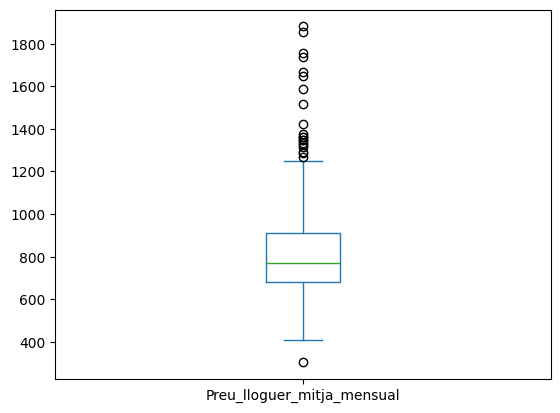

In [33]:
df_lloguer_unique['Preu_lloguer_mitja_mensual'].plot(kind="box")

<Axes: >

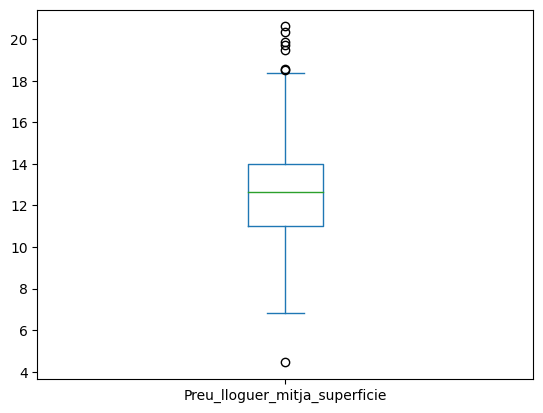

In [34]:
df_lloguer_unique['Preu_lloguer_mitja_superficie'].plot(kind="box")

In [35]:
df_lloguer_unique.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Trimestre,292.0,2.500000,1.119953,1.00,1.75,2.50,3.25,4.00
Codi_Districte,292.0,6.246575,2.793123,1.00,4.00,7.00,8.00,10.00
Codi_Barri,292.0,37.000000,21.107481,1.00,19.00,37.00,55.00,73.00
Preu_lloguer_mitja_mensual,273.0,829.380403,253.210128,302.52,680.80,771.78,912.51,1882.42
Preu_lloguer_mitja_superficie,273.0,12.638059,2.479090,4.45,11.00,12.64,13.97,20.61


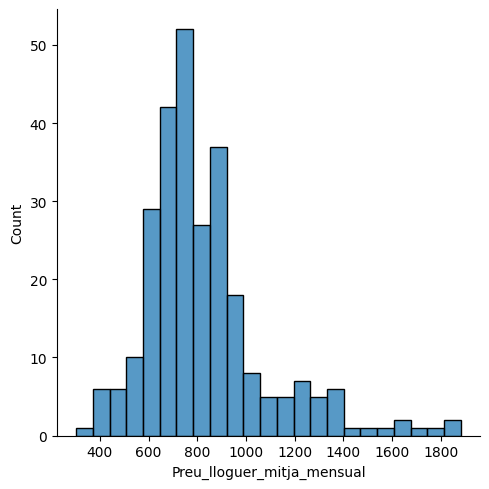

In [38]:
sns.displot(df_lloguer_unique['Preu_lloguer_mitja_mensual'])  #Podemos obrservar como la mayoría de precio oscila entre 600€ y 1000€ aprox (€/mes)

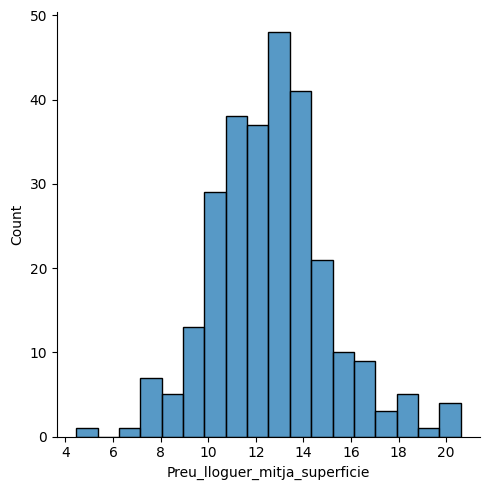

In [39]:
sns.displot(df_lloguer_unique['Preu_lloguer_mitja_superficie'])   #Podemos obrservar como la mayoría de precio oscila entre 10€ y 15€ aprox ( €/m2)

# Imputación de valores nulos en precio

In [48]:
df_lloguer_unique.isnull().sum() #Seguimos teniendo la misma cantidad a pesar de los cambios, así que es buena señal

Trimestre                             0
Codi_Districte                        0
Nom_Districte                         0
Codi_Barri                            0
Nom_Barri                             0
Preu_lloguer_mitja_mensual           19
Preu_lloguer_mitja_superficie        19
Superficie_Mitjana_Habitatge_(m2)     0
dtype: int64

#### Usaremos el KNNImputer para imputar los precios en función de sus vecinos más cercanos, de esta manera podemos imputar nulos y el agoritmo buscará aquellos más parecidos (barrio, distrito,etc), para imputar valores 

In [49]:
imputer = KNNImputer()

In [50]:
df_lloguer_unique.describe(include = np.number).columns

Index(['Trimestre', 'Codi_Districte', 'Codi_Barri',
       'Preu_lloguer_mitja_mensual', 'Preu_lloguer_mitja_superficie',
       'Superficie_Mitjana_Habitatge_(m2)'],
      dtype='object')

In [51]:
df_lloguer_unique_num = df_lloguer_unique[
    ['Trimestre', 
     'Codi_Districte', 
     'Codi_Barri',
     'Preu_lloguer_mitja_mensual', 
     'Preu_lloguer_mitja_superficie',
     'Superficie_Mitjana_Habitatge_(m2)']]

In [52]:
df_lloguer_unique_num = imputer.fit_transform(df_lloguer_unique_num)

In [53]:
df_lloguer_unique_num.isnull().sum() #Ya hemos imputado los valores nulos

Trimestre                            0
Codi_Districte                       0
Codi_Barri                           0
Preu_lloguer_mitja_mensual           0
Preu_lloguer_mitja_superficie        0
Superficie_Mitjana_Habitatge_(m2)    0
dtype: int64

#### Vamos a concatenar las otras columnas que no hemos seleccionado antes para poder concatenar con el df_poblacio

#### Como no hemos alterado el orden del dataset podemos hacer un concat en axis=1, podemos estar seguros de que seguirá el mismo orden que debería

In [54]:
df_lloguer_unique_clean = pd.concat([df_lloguer_unique_num,df_lloguer_unique[['Nom_Districte','Nom_Barri']]],axis=1)

In [55]:
df_lloguer_unique_clean

,Trimestre,Codi_Districte,Codi_Barri,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie,Superficie_Mitjana_Habitatge_(m2),Nom_Districte,Nom_Barri
id,,,,,,,,
1_1_1,1.0,1.0,1.0,734.99,13.50,65.6,Ciutat Vella,el Raval
1_1_2,1.0,1.0,2.0,905.26,14.14,88.2,Ciutat Vella,el Barri Gòtic
1_1_3,1.0,1.0,3.0,722.78,19.46,46.7,Ciutat Vella,la Barceloneta
1_1_4,1.0,1.0,4.0,895.28,15.01,72.6,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera"
1_2_5,1.0,2.0,5.0,871.08,12.77,81.9,Eixample,el Fort Pienc
...,...,...,...,...,...,...,...,...
4_10_69,4.0,10.0,69.0,1233.01,16.51,86.9,Sant Martí,Diagonal Mar i el Front Marítim del Poblenou
4_10_70,4.0,10.0,70.0,621.32,10.40,63.8,Sant Martí,el Besòs i el Maresme
4_10_71,4.0,10.0,71.0,864.09,12.66,75.1,Sant Martí,Provençals del Poblenou


# df_poblacio -- análisis y limpieza

In [56]:
report_df(df_poblacio)

df_poblacio.head(2)

El tamaño del dataset es 18980 filas y 7 columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18980 entries, 0 to 18979
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Codi_Districte  18980 non-null  int64 
 1   Nom_Districte   18980 non-null  object
 2   Codi_Barri      18980 non-null  int64 
 3   Nom_Barri       18980 non-null  object
 4   Concepte        18980 non-null  object
 5   Rang_soroll     18980 non-null  object
 6   Valor           18980 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.0+ MB
None

Tenemos un total de 0 nulos

Hay 0 duplicados


,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%


In [57]:
df_poblacio.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
Codi_Districte,18980.0,6.246575,2.788409,1.0,4.0,7.0,8.0,10.0
Codi_Barri,18980.0,37.000000,21.071863,1.0,19.0,37.0,55.0,73.0


In [60]:
df_poblacio.describe(exclude=np.number).T

,count,unique,top,freq
Nom_Districte,18980,10,Nou Barris,3380
Nom_Barri,18980,73,el Raval,260
Concepte,18980,26,TOTAL_D,730
Rang_soroll,18980,10,<40 dB,1898
Valor,18980,3104,0.00%,9953


In [61]:
df_poblacio.isnull().sum()

Codi_Districte    0
Nom_Districte     0
Codi_Barri        0
Nom_Barri         0
Concepte          0
Rang_soroll       0
Valor             0
dtype: int64

In [62]:
df_poblacio[(df_poblacio['Codi_Districte']==1) & (df_poblacio['Codi_Barri']==1)]

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%
2,1,Ciutat Vella,1,el Raval,TOTAL_D,45-50 dB,7.38%
3,1,Ciutat Vella,1,el Raval,TOTAL_D,50-55 dB,11.97%
4,1,Ciutat Vella,1,el Raval,TOTAL_D,55-60 dB,19.85%
...,...,...,...,...,...,...,...
18255,1,Ciutat Vella,1,el Raval,PARCS_D,60-65 dB,0.00%
18256,1,Ciutat Vella,1,el Raval,PARCS_D,65-70 dB,0.00%
18257,1,Ciutat Vella,1,el Raval,PARCS_D,70-75 dB,0.00%
18258,1,Ciutat Vella,1,el Raval,PARCS_D,75-80 dB,0.00%


In [63]:
df_poblacio[(df_poblacio['Codi_Districte']==1)]['Codi_Barri'].nunique()

4

In [64]:
df_poblacio['Codi_Districte'].nunique()

10

In [65]:
df_poblacio['Codi_Barri'].nunique()

73

In [66]:
df_poblacio['Rang_soroll'].nunique()

10

In [105]:
df_poblacio['Concepte'].unique() 
#Juntaremos etiquetas y haremos menos grupos en Conceptos, ya que muchos forman parte de grupos similares

array(['TOTAL_D', 'TOTAL_E', 'TOTAL_N', 'TOTAL_DEN', 'TRANSIT_D',
       'TRANSIT_E', 'TRANSIT_N', 'TRANSIT_DEN', 'GI_TR_D', 'GI_TR_E',
       'GI_TR_N', 'GI_TR_DEN', 'FFCC_D', 'FFCC_E', 'FFCC_N', 'FFCC_DEN',
       'INDUST_D', 'INDUST_E', 'INDUST_N', 'INDUST_DEN', 'VIANANTS_D',
       'VIANANTS_E', 'OCI_N', 'PATIS_D', 'PATIS_E', 'PARCS_D'],
      dtype=object)

In [69]:
# Clasifficación general de Concepte, según la web de www.barcelona.cat, lo divide en estas 9 categorias diferentes:

# TOTAL
# PATIS
# OCI
# VIANANTS
# INDUST
# FFCC
# GI
# TRANSIT
# PARCS

In [68]:
df_poblacio.index.nunique()

18980

In [70]:
df_poblacio.columns

Index(['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri',
       'Concepte', 'Rang_soroll', 'Valor'],
      dtype='object')

In [108]:
# agrupación de etiquetas

juntar_etiquetas(df_poblacio, 'Concepte', 'TOTAL', 'TOTAL')
juntar_etiquetas(df_poblacio, 'Concepte', 'TRANSIT', 'TRANSIT')
juntar_etiquetas(df_poblacio, 'Concepte', 'GI_TR', 'GI_TR')
juntar_etiquetas(df_poblacio, 'Concepte', 'FFCC', 'FFCC')
juntar_etiquetas(df_poblacio, 'Concepte', 'INDUST', 'INDUST')
juntar_etiquetas(df_poblacio, 'Concepte', 'VIANANTS', 'VIANANTS')
juntar_etiquetas(df_poblacio, 'Concepte', 'OCI', 'OCI')
juntar_etiquetas(df_poblacio, 'Concepte', 'PATIS', 'PATIS')
juntar_etiquetas(df_poblacio, 'Concepte', 'PARCS', 'PARCS')

In [110]:
df_poblacio['Concepte'].value_counts()

Concepte
TOTAL       2920
TRANSIT     2920
GI_TR       2920
FFCC        2920
INDUST      2920
VIANANTS    1460
PATIS       1460
OCI          730
PARCS        730
Name: count, dtype: int64

In [111]:
df_poblacio['Valor'] = df_poblacio['Valor'].str.split("%",expand=True)[[0]]
df_poblacio.rename(columns = {'Valor':'Valor_porcentaje'},inplace=True)

In [113]:
df_poblacio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18980 entries, 0 to 18979
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Codi_Districte    18980 non-null  int64 
 1   Nom_Districte     18980 non-null  object
 2   Codi_Barri        18980 non-null  int64 
 3   Nom_Barri         18980 non-null  object
 4   Concepte          18980 non-null  object
 5   Rang_soroll       18980 non-null  object
 6   Valor_porcentaje  18980 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.0+ MB


In [114]:
df_poblacio['Valor_porcentaje'] = df_poblacio['Valor_porcentaje'].astype(float) #Convertimos a numerico los valores

In [116]:
#Creación de id único con Trimestre, Distrito y Barrio
df_poblacio['id'] = df_poblacio['Codi_Districte'].apply(str)  + "_" + df_poblacio['Codi_Barri'].apply(str) + "_" + df_poblacio['Rang_soroll']

df_poblacio.set_index('id',inplace=True)

In [117]:
df_poblacio['media_valor_concepte'] = df_poblacio.groupby([df_poblacio.index,'Concepte'])[['Valor_porcentaje']].transform(np.mean)

In [118]:
df_poblacio[df_poblacio['Concepte'] == 'VIANANTS']

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor_porcentaje,media_valor_concepte
id,,,,,,,,
1_1_<40 dB,1,Ciutat Vella,1,el Raval,VIANANTS,<40 dB,57.69,58.410
1_1_40-45 dB,1,Ciutat Vella,1,el Raval,VIANANTS,40-45 dB,13.35,15.075
1_1_45-50 dB,1,Ciutat Vella,1,el Raval,VIANANTS,45-50 dB,10.90,9.970
1_1_50-55 dB,1,Ciutat Vella,1,el Raval,VIANANTS,50-55 dB,10.81,9.420
1_1_55-60 dB,1,Ciutat Vella,1,el Raval,VIANANTS,55-60 dB,6.47,6.245
...,...,...,...,...,...,...,...,...
10_73_60-65 dB,10,Sant Martí,73,la Verneda i la Pau,VIANANTS,60-65 dB,0.00,0.000
10_73_65-70 dB,10,Sant Martí,73,la Verneda i la Pau,VIANANTS,65-70 dB,0.00,0.000
10_73_70-75 dB,10,Sant Martí,73,la Verneda i la Pau,VIANANTS,70-75 dB,0.00,0.000


In [ ]:
df_poblacio.drop('Valor_porcentaje',axis=1,inplace=True)
df_poblacio.reset_index(drop=True,inplace=True)
df_poblacio

In [ ]:
df_poblacio = pd.pivot_table(df_poblacio,index = ['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri','Rang_soroll'], columns = 'Concepte',values = "media_valor_concepte")
df_poblacio.reset_index(inplace=True)

In [125]:
df_poblacio[(df_poblacio['Codi_Districte']==1) & (df_poblacio['Codi_Barri']==1)] 
# Comprobamos que dentro de las columnas de concepto nos de el 100% a los largo del rango de ruido

Concepte,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Rang_soroll,FFCC,GI_TR,INDUST,OCI,PARCS,PATIS,TOTAL,TRANSIT,VIANANTS
0,1,Ciutat Vella,1,el Raval,40-45 dB,0.0,5.3400,0.0,4.97,0.0,0.000,20.2875,23.1625,15.075
1,1,Ciutat Vella,1,el Raval,45-50 dB,0.0,1.7425,0.0,2.53,0.0,0.000,8.9775,9.3350,9.970
2,1,Ciutat Vella,1,el Raval,50-55 dB,0.0,0.8500,0.0,1.80,0.0,0.825,11.8725,12.8425,9.420
3,1,Ciutat Vella,1,el Raval,55-60 dB,0.0,0.6025,0.0,5.79,0.0,1.335,16.3775,15.2550,6.245
4,1,Ciutat Vella,1,el Raval,60-65 dB,0.0,0.7325,0.0,8.88,0.0,0.890,14.8850,10.7925,0.880
5,1,Ciutat Vella,1,el Raval,65-70 dB,0.0,0.6500,0.0,0.14,0.0,0.000,7.4325,5.3225,0.000
6,1,Ciutat Vella,1,el Raval,70-75 dB,0.0,0.6750,0.0,0.00,0.0,0.000,2.0925,1.7300,0.000
7,1,Ciutat Vella,1,el Raval,75-80 dB,0.0,0.0000,0.0,0.00,0.0,0.000,0.0250,0.0250,0.000
8,1,Ciutat Vella,1,el Raval,<40 dB,100.0,89.4075,100.0,75.89,100.0,96.950,18.0500,21.5350,58.410
9,1,Ciutat Vella,1,el Raval,>=80 dB,0.0,0.0000,0.0,0.00,0.0,0.000,0.0000,0.0000,0.000


In [130]:
# Realizar Label Encoder a Rang Soroll

le = LabelEncoder()
df_poblacio['Rang_Soroll']= le.fit_transform(df_poblacio['Rang_Soroll'])

KeyError: 'Rang_Soroll'